# Chapter 3.1

## Importing Libraries

In [1]:
from __future__ import absolute_import, division, print_function
from __future__ import unicode_literals

In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import copy
import tqdm
from hfunc import models
from hfunc import metrics

## Set seed

In [3]:
np.random.seed(2020)

## Node remover function

In [4]:
def remove_random_nodes(n, weights, to_consider=None):
    if to_consider:
        to_drop = np.random.choice(to_consider, n, replace=False)
    else:
        to_drop = np.random.choice(len(weights[1]), n, replace=False)
    for i in to_drop:
        weights[0][:,i] = 0
        weights[1][i] = 0
        weights[2][i,:] = 0
    return weights, to_drop

In [5]:
def shrink_model_randomly(model, acc, loss, weights, n, to_test, x_train, y_train, v=0):
    new_loss = loss
    new_acc = acc
    ba = acc
    bl = loss
    best_model = copy.deepcopy(weights)
    num_removed = 0
    to_consider = list(np.arange(len(weights[1])))
    for _ in range(to_test):
        best_score = 0
        new = copy.deepcopy(best_model)
        new, dropped = remove_random_nodes(n, new, to_consider)
        model.set_weights(new)
        new_loss, new_acc = model.evaluate(x_train, y_train, verbose=v)
        score = (1 - (new_loss / bl)) + ((new_acc / ba) - 1)
        if best_score < score:
            ba = new_acc
            bl = new_loss
            best_model = copy.deepcopy(new)
            num_removed += n
            for node in dropped:
                to_consider.remove(node)
    return best_model, num_removed

### Single-Layer ANN

## MNIST

In [6]:
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0  # Converting interger values to floats (0 to 1)

In [7]:
model, r = models.train_basic_ANN(x_train, y_train, 128, (x_test, y_test), epochs=5)

In [8]:
loss, acc = model.evaluate(x_test, y_test, verbose=2)

313/313 - 0s - loss: 0.0879 - accuracy: 0.9724


In [9]:
original_weights = model.get_weights()

In [10]:
nums_to_rem = [64, 32, 16, 8, 4, 2, 1]
trials = 1000
new_accs = []
new_losses = []
for ntr in nums_to_rem:
    accs = []
    losses = []
    for _ in tqdm.trange(trials):
        tmp = copy.deepcopy(original_weights)
        tmp, _ = remove_random_nodes(ntr, tmp)
        model.set_weights(tmp)
        l, a = model.evaluate(x_test, y_test, verbose=0)
        accs += [a]
        losses += [l]
    new_accs += [accs]
    new_losses += [losses]

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [04:21<00:00,  3.82it/s]


In [11]:
A = pd.DataFrame(new_accs, index = nums_to_rem)
A.to_csv('../../../results/accs_random_removal_mnist.csv')
A = A.T
A.describe()

,64,32,16,8,4,2,1
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,0.848527,0.942736,0.961917,0.968121,0.970445,0.971441,0.971984
std,0.041705,0.013024,0.005639,0.003178,0.001986,0.001336,0.000920
min,0.683100,0.886100,0.927000,0.952300,0.960200,0.962400,0.968700
25%,0.821525,0.936400,0.958800,0.966400,0.969400,0.970800,0.971500
50%,0.854600,0.944800,0.962800,0.968500,0.970800,0.971700,0.972100
75%,0.880300,0.952600,0.966000,0.970400,0.971900,0.972400,0.972600
max,0.932800,0.966200,0.972400,0.974900,0.974400,0.974300,0.973600


In [12]:
L = pd.DataFrame(new_losses, index = nums_to_rem)
L.to_csv('../../../results/losses_random_removal_mnist.csv')
L = L.T
L.describe()

,64,32,16,8,4,2,1
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,0.446568,0.179376,0.121617,0.102391,0.094847,0.091354,0.089476
std,0.107404,0.036119,0.016426,0.009524,0.005803,0.003836,0.002613
min,0.230566,0.112669,0.090062,0.084443,0.083758,0.083917,0.084770
25%,0.366245,0.151553,0.110106,0.095662,0.090660,0.088709,0.087741
50%,0.431301,0.173848,0.118624,0.101203,0.093718,0.090672,0.088999
75%,0.511249,0.197996,0.130489,0.106858,0.098065,0.093192,0.090758
max,0.988322,0.340889,0.223338,0.148904,0.129176,0.124468,0.099743


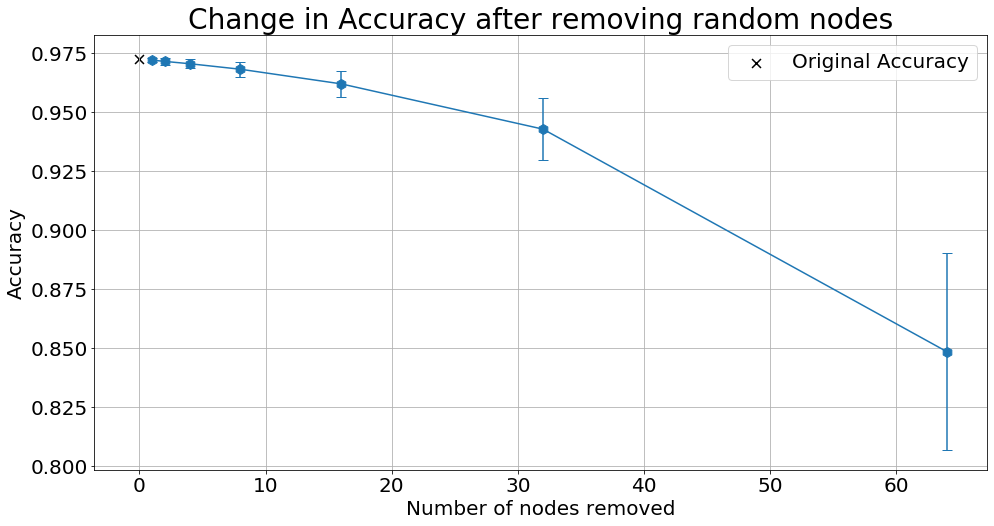

In [13]:
ma = A.mean().to_numpy()
stda = A.std().to_numpy()
plt.rcParams["figure.figsize"] = (16,8)
plt.errorbar(x=nums_to_rem, y=ma, yerr=stda, capsize=5, marker='h', markersize=10, alpha=1)
plt.scatter(x=0, y=acc, marker='x', color='black', label="Original Accuracy", s=80)
plt.legend(fontsize=20)
plt.title("Change in Accuracy after removing random nodes", size=28)
plt.xlabel("Number of nodes removed", size=20)
plt.xticks(fontsize=20)
plt.ylabel("Accuracy", size=20)
plt.yticks(fontsize=20)
plt.grid(True)
plt.savefig("../../../figures/Accuracy_change_random_removal_mnist.png")

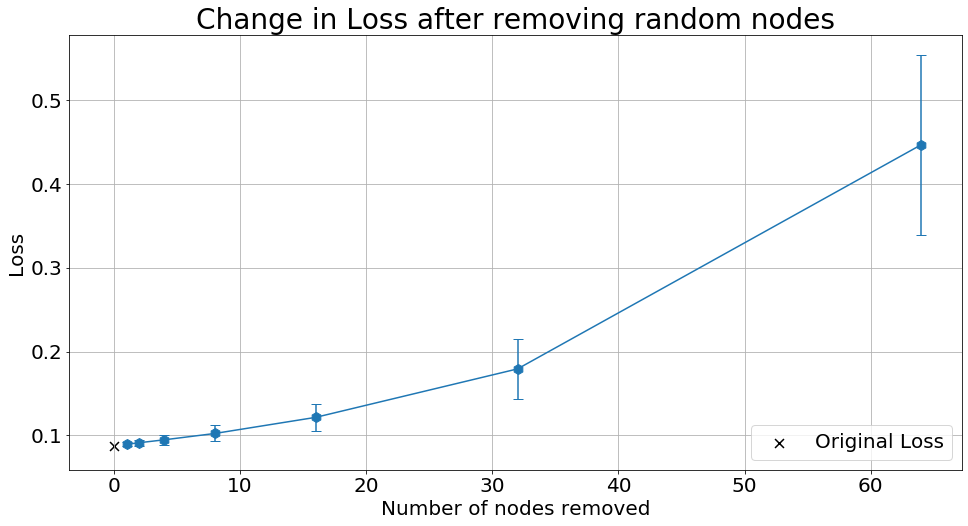

In [14]:
ml = L.mean().to_numpy()
stdl = L.std().to_numpy()
plt.errorbar(x=nums_to_rem, y=ml, yerr=stdl, capsize=5, marker='h', markersize=10, alpha=1)
plt.scatter(x=0, y=loss, marker='x', color='black', label="Original Loss", s=80)
plt.legend(loc='lower right', fontsize=20)
plt.title("Change in Loss after removing random nodes", size=28)
plt.xlabel("Number of nodes removed", size=20)
plt.xticks(fontsize=20)
plt.ylabel("Loss", size=20)
plt.yticks(fontsize=20)
plt.grid(True)
plt.savefig("../../../figures/Loss_change_random_removal_mnist.png")

In [15]:
model.set_weights(original_weights)
train_loss, train_acc = model.evaluate(x_train, y_train, verbose=0)
nums_to_rem = [8, 4, 3, 2, 1]
trials = 20
check = 64
new_accs = []
new_losses = []
nums_rem = []
for ntr in nums_to_rem:
    accs = []
    losses = []
    num_rem = []
    for _ in tqdm.trange(trials):
        tmp, nr = shrink_model_randomly(model, train_acc, train_loss, original_weights, ntr, check, x_train, y_train)
        model.set_weights(tmp)
        l, a = model.evaluate(x_test, y_test, verbose=0)
        accs += [a]
        losses += [l]
        num_rem += [nr]
    new_accs += [accs]
    new_losses += [losses]
    nums_rem += [num_rem]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [25:16<00:00, 75.84s/it]


In [16]:
A = pd.DataFrame(new_accs, index = nums_to_rem)
A.to_csv('../../../results/accs_random_removal_improving_mnist.csv')
A = A.T
A.describe()

,8,4,3,2,1
count,20.000000,20.000000,20.000000,20.000000,20.000000
mean,0.972635,0.973300,0.973735,0.974225,0.975070
std,0.000452,0.000771,0.000977,0.000927,0.000643
min,0.972400,0.972300,0.972300,0.972800,0.973900
25%,0.972400,0.972825,0.972900,0.973575,0.974575
50%,0.972400,0.973200,0.973700,0.973900,0.975100
75%,0.972550,0.973725,0.974500,0.974950,0.975600
max,0.973900,0.975000,0.976000,0.976100,0.976200


In [17]:
L = pd.DataFrame(new_losses, index = nums_to_rem)
L.to_csv('../../../results/losses_random_removal_improving_mnist.csv')
L = L.T
L.describe()

,8,4,3,2,1
count,20.000000,20.000000,20.000000,20.000000,20.000000
mean,0.087305,0.085965,0.084898,0.084107,0.081889
std,0.001489,0.002041,0.001461,0.002319,0.001942
min,0.082889,0.081235,0.081726,0.079564,0.077565
25%,0.087862,0.084700,0.084096,0.082943,0.080665
50%,0.087934,0.086520,0.084675,0.084117,0.081291
75%,0.087934,0.086980,0.086087,0.085754,0.083135
max,0.088868,0.089754,0.087224,0.087849,0.085597


In [18]:
NR = pd.DataFrame(nums_rem, index = nums_to_rem)
NR.to_csv('../../../results/number_nodes_removed_random_removal_improving_mnist.csv')
NR = NR.T
NR.describe()

,8,4,3,2,1
count,20.000000,20.000000,20.000000,20.000000,20.000000
mean,2.400000,5.800000,8.250000,8.900000,7.400000
std,3.761299,3.302312,2.731396,2.789076,1.698296
min,0.000000,0.000000,3.000000,4.000000,5.000000
25%,0.000000,4.000000,6.000000,7.500000,6.000000
50%,0.000000,4.000000,9.000000,8.000000,7.000000
75%,8.000000,8.000000,9.750000,10.000000,8.250000
max,8.000000,12.000000,12.000000,16.000000,11.000000


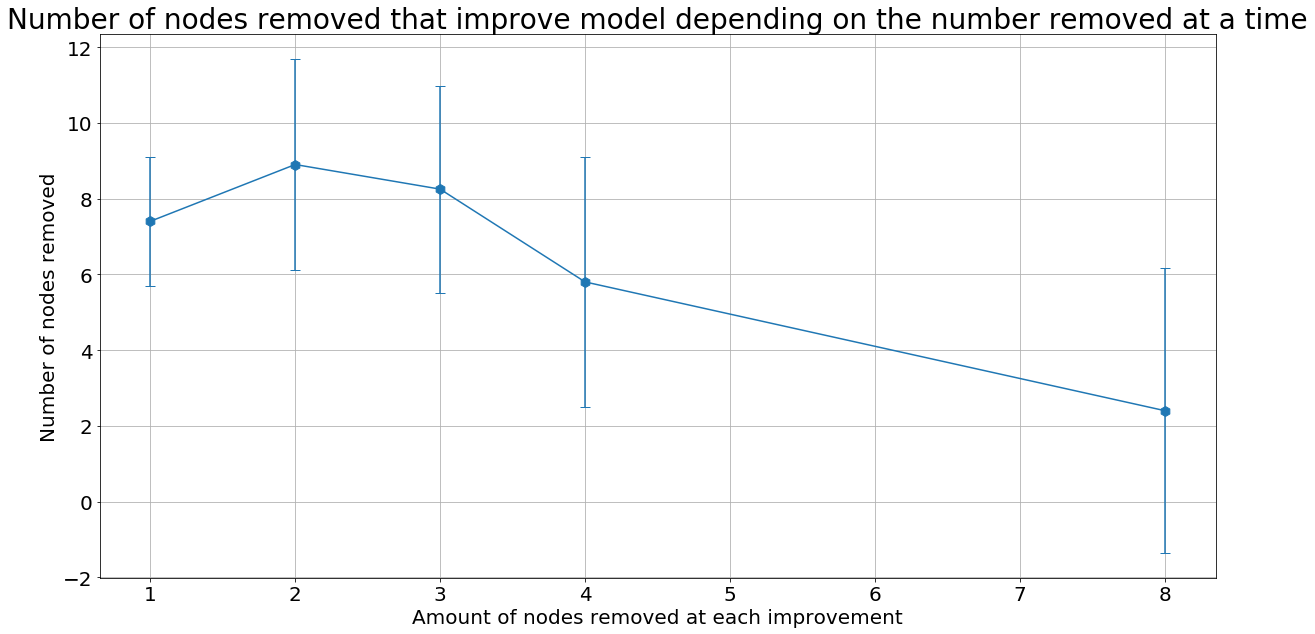

In [19]:
mnr = NR.mean().to_numpy()
stdnr = NR.std().to_numpy()
plt.rcParams["figure.figsize"] = (20,10)
plt.errorbar(x=nums_to_rem, y=mnr, yerr=stdnr, capsize=5, marker='h', markersize=10, alpha=1)
plt.title("Number of nodes removed that improve model depending on the number removed at a time", size=28)
plt.xlabel("Amount of nodes removed at each improvement", size=20)
plt.xticks(fontsize=20)
plt.ylabel("Number of nodes removed", size=20)
plt.yticks(fontsize=20)
plt.grid(True)
plt.savefig("../../../figures/Num_rem_vs_size_removed_mnist.png")

In [20]:
num_removed = [nr for num_rem in nums_rem for nr in num_rem]
new_accs = [a for accs in new_accs for a in accs]
new_losses = [l for losses in new_losses for l in losses]

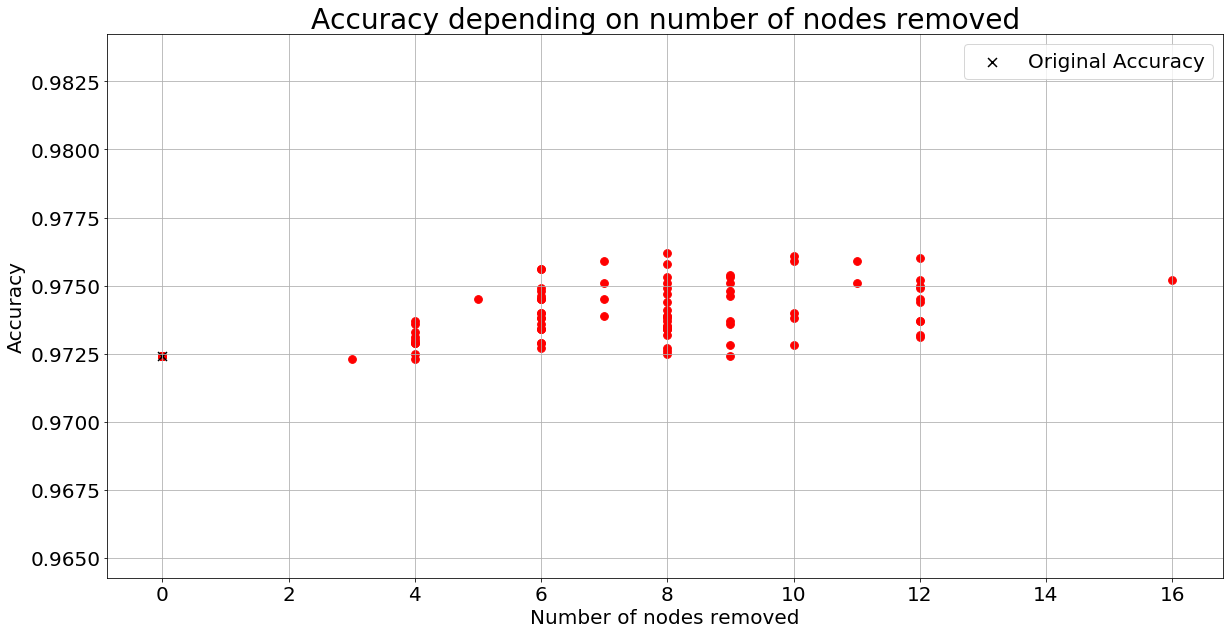

In [21]:
plt.scatter(x=num_removed, y=new_accs, marker='o', color='red', s=60)
plt.scatter(x=0, y=acc, marker='x', color='black', label="Original Accuracy", s=80)
plt.legend(fontsize=20)
plt.title("Accuracy depending on number of nodes removed", size=28)
plt.xlabel("Number of nodes removed", size=20)
plt.xticks(fontsize=20)
plt.ylabel("Accuracy", size=20)
plt.yticks(fontsize=20)
plt.grid(True)
plt.savefig("../../../figures/Accuracy_vs_nodes_removed_mnist.png")

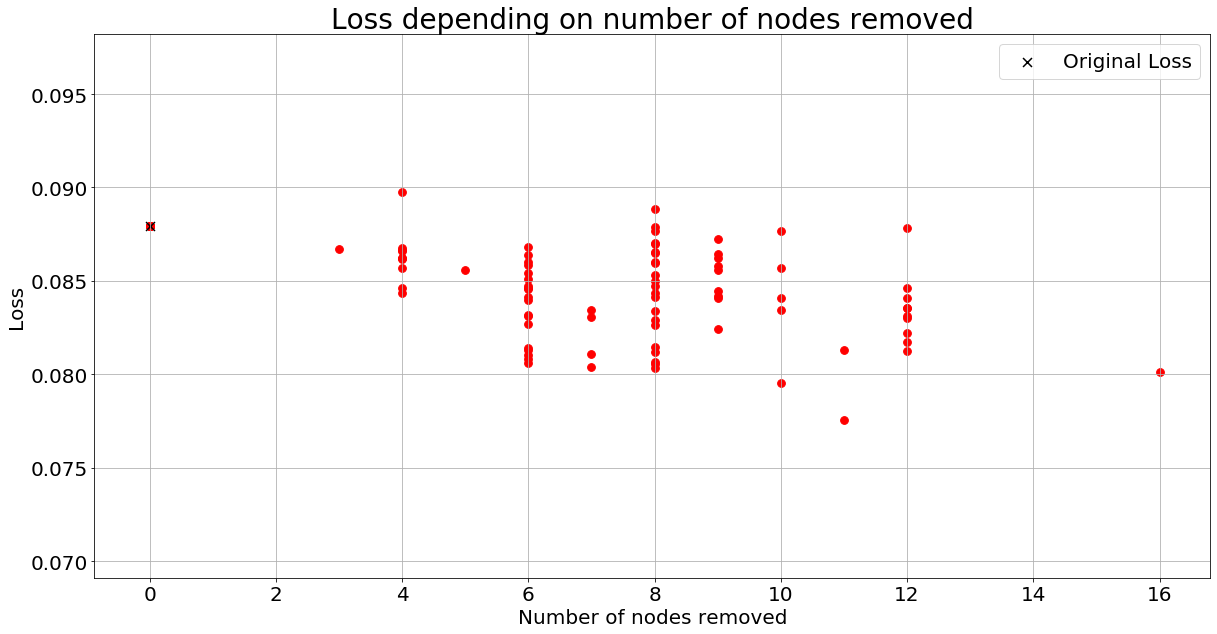

In [22]:
plt.scatter(x=num_removed, y=new_losses, marker='o', color='red', s=60)
plt.scatter(x=0, y=loss, marker='x', color='black', label="Original Loss", s=80)
plt.legend(fontsize=20)
plt.title("Loss depending on number of nodes removed", size=28)
plt.xlabel("Number of nodes removed", size=20)
plt.xticks(fontsize=20)
plt.ylabel("Loss", size=20)
plt.yticks(fontsize=20)
plt.grid(True)
plt.savefig("../../../figures/Loss_vs_nodes_removed_mnist.png")

## Fashion MNIST

In [23]:
fmnist = tf.keras.datasets.fashion_mnist
(x_train, y_train), (x_test, y_test) = fmnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0  # Converting interger values to floats (0 to 1)

In [24]:
model, r = models.train_basic_ANN(x_train, y_train, 128, (x_test, y_test), epochs=10)

In [25]:
loss, acc = model.evaluate(x_test, y_test, verbose=2)

313/313 - 0s - loss: 0.3557 - accuracy: 0.8685


In [26]:
original_weights = model.get_weights()

In [27]:
nums_to_rem = [64, 32, 16, 8, 4, 2, 1]
trials = 1000
new_accs = []
new_losses = []
for ntr in nums_to_rem:
    accs = []
    losses = []
    for _ in tqdm.trange(trials):
        tmp = copy.deepcopy(original_weights)
        tmp, _ = remove_random_nodes(ntr, tmp)
        model.set_weights(tmp)
        l, a = model.evaluate(x_test, y_test, verbose=0)
        accs += [a]
        losses += [l]
    new_accs += [accs]
    new_losses += [losses]

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [04:22<00:00,  3.82it/s]


In [28]:
A = pd.DataFrame(new_accs, index = nums_to_rem)
A.to_csv('../../../results/accs_random_removal_fmnist.csv')
A = A.T
A.describe()

,64,32,16,8,4,2,1
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,0.739420,0.829493,0.854300,0.861841,0.865154,0.866732,0.867660
std,0.044278,0.019952,0.009643,0.005855,0.004244,0.002991,0.002112
min,0.549300,0.738200,0.805000,0.840500,0.847000,0.847000,0.857800
25%,0.717075,0.818975,0.849100,0.858200,0.863200,0.865300,0.867000
50%,0.743700,0.833600,0.855800,0.862600,0.865900,0.867400,0.868400
75%,0.769825,0.844100,0.861100,0.866300,0.868100,0.868500,0.868600
max,0.830700,0.865600,0.874700,0.876700,0.874500,0.873500,0.872600


In [29]:
L = pd.DataFrame(new_losses, index = nums_to_rem)
L.to_csv('../../../results/losses_random_removal_fmnist.csv')
L = L.T
L.describe()

,64,32,16,8,4,2,1
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,0.706201,0.460722,0.393947,0.373015,0.364346,0.360122,0.357810
std,0.118168,0.049531,0.022848,0.013691,0.009820,0.007008,0.004880
min,0.472961,0.372549,0.351513,0.344837,0.343449,0.345162,0.345931
25%,0.623537,0.424450,0.377217,0.362925,0.357621,0.355903,0.355735
50%,0.686746,0.450386,0.389976,0.371131,0.362512,0.358449,0.356431
75%,0.761893,0.485715,0.406018,0.381101,0.369336,0.363180,0.359089
max,1.364899,0.707925,0.510603,0.429679,0.403501,0.405484,0.379082


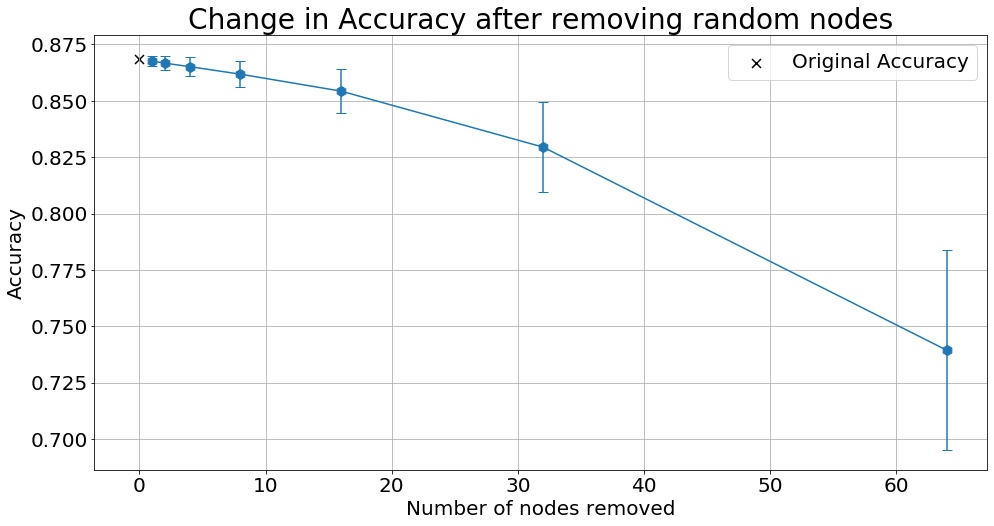

In [30]:
ma = A.mean().to_numpy()
stda = A.std().to_numpy()
plt.rcParams["figure.figsize"] = (16,8)
plt.errorbar(x=nums_to_rem, y=ma, yerr=stda, capsize=5, marker='h', markersize=10, alpha=1)
plt.scatter(x=0, y=acc, marker='x', color='black', label="Original Accuracy", s=80)
plt.legend(fontsize=20)
plt.title("Change in Accuracy after removing random nodes", size=28)
plt.xlabel("Number of nodes removed", size=20)
plt.xticks(fontsize=20)
plt.ylabel("Accuracy", size=20)
plt.yticks(fontsize=20)
plt.grid(True)
plt.savefig("../../../figures/Accuracy_change_random_removal_fmnist.png")

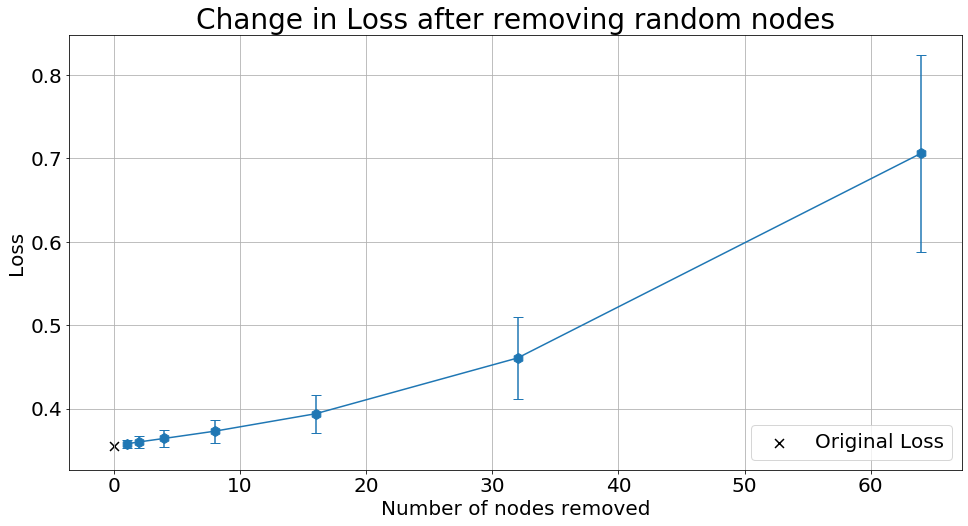

In [31]:
ml = L.mean().to_numpy()
stdl = L.std().to_numpy()
plt.errorbar(x=nums_to_rem, y=ml, yerr=stdl, capsize=5, marker='h', markersize=10, alpha=1)
plt.scatter(x=0, y=loss, marker='x', color='black', label="Original Loss", s=80)
plt.legend(loc='lower right', fontsize=20)
plt.title("Change in Loss after removing random nodes", size=28)
plt.xlabel("Number of nodes removed", size=20)
plt.xticks(fontsize=20)
plt.ylabel("Loss", size=20)
plt.yticks(fontsize=20)
plt.grid(True)
plt.savefig("../../../figures/Loss_change_random_removal_fmnist.png")

In [32]:
model.set_weights(original_weights)
train_loss, train_acc = model.evaluate(x_train, y_train, verbose=0)
nums_to_rem = [8, 4, 3, 2, 1]
trials = 20
check = 64
new_accs = []
new_losses = []
nums_rem = []
for ntr in nums_to_rem:
    accs = []
    losses = []
    num_rem = []
    for _ in tqdm.trange(trials):
        tmp, nr = shrink_model_randomly(model, train_acc, train_loss, original_weights, ntr, check, x_train, y_train)
        model.set_weights(tmp)
        l, a = model.evaluate(x_test, y_test, verbose=0)
        accs += [a]
        losses += [l]
        num_rem += [nr]
    new_accs += [accs]
    new_losses += [losses]
    nums_rem += [num_rem]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [25:14<00:00, 75.74s/it]


In [33]:
A = pd.DataFrame(new_accs, index = nums_to_rem)
A.to_csv('../../../results/accs_random_removal_improving_fmnist.csv')
A = A.T
A.describe()

,8,4,3,2,1
count,20.000000,20.000000,20.000000,20.000000,20.000000
mean,0.870585,0.873075,0.874295,0.875200,0.874875
std,0.001879,0.001823,0.001822,0.001772,0.002274
min,0.868500,0.870500,0.871800,0.871800,0.870200
25%,0.868500,0.871725,0.872950,0.874250,0.873350
50%,0.870600,0.872700,0.873900,0.875000,0.874600
75%,0.871550,0.874125,0.875775,0.876350,0.877000
max,0.874800,0.876400,0.877500,0.879400,0.878200


In [34]:
L = pd.DataFrame(new_losses, index = nums_to_rem)
L.to_csv('../../../results/losses_random_removal_improving_fmnist.csv')
L = L.T
L.describe()

,8,4,3,2,1
count,20.000000,20.000000,20.000000,20.000000,20.000000
mean,0.352263,0.346888,0.344741,0.344445,0.343323
std,0.002992,0.003630,0.003713,0.003941,0.003447
min,0.347569,0.340290,0.337891,0.335182,0.338291
25%,0.349627,0.344326,0.341571,0.342375,0.341254
50%,0.352323,0.346583,0.344369,0.344093,0.342546
75%,0.355735,0.349196,0.347719,0.346062,0.344211
max,0.355735,0.355291,0.351043,0.351513,0.350519


In [35]:
NR = pd.DataFrame(nums_rem, index = nums_to_rem)
NR.to_csv('../../../results/number_nodes_removed_random_removal_improving_fmnist.csv')
NR = NR.T
NR.describe()

,8,4,3,2,1
count,20.000000,20.000000,20.000000,20.000000,20.000000
mean,5.600000,8.400000,10.650000,8.600000,5.500000
std,3.761299,3.408967,3.150188,1.846761,1.572795
min,0.000000,4.000000,3.000000,6.000000,2.000000
25%,0.000000,7.000000,9.000000,8.000000,5.000000
50%,8.000000,8.000000,12.000000,8.000000,5.500000
75%,8.000000,12.000000,12.000000,10.000000,6.250000
max,8.000000,16.000000,18.000000,12.000000,8.000000


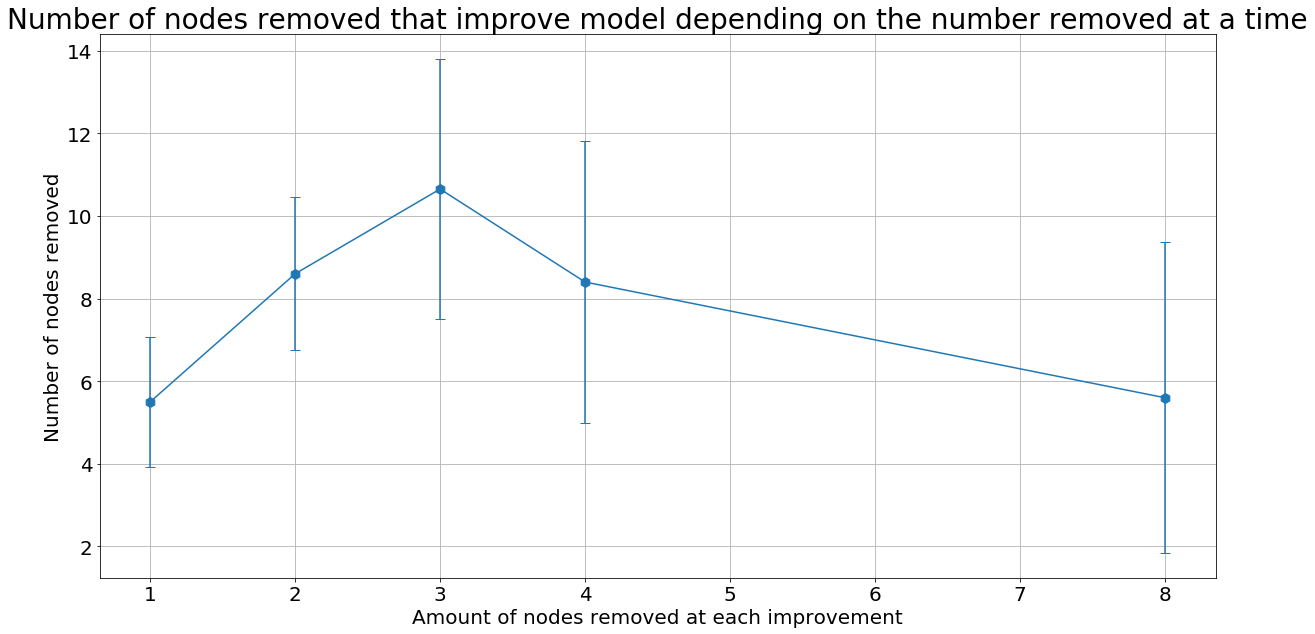

In [36]:
mnr = NR.mean().to_numpy()
stdnr = NR.std().to_numpy()
plt.rcParams["figure.figsize"] = (20,10)
plt.errorbar(x=nums_to_rem, y=mnr, yerr=stdnr, capsize=5, marker='h', markersize=10, alpha=1)
plt.title("Number of nodes removed that improve model depending on the number removed at a time", size=28)
plt.xlabel("Amount of nodes removed at each improvement", size=20)
plt.xticks(fontsize=20)
plt.ylabel("Number of nodes removed", size=20)
plt.yticks(fontsize=20)
plt.grid(True)
plt.savefig("../../../figures/Num_rem_vs_size_removed_fmnist.png")

In [37]:
num_removed = [nr for num_rem in nums_rem for nr in num_rem]
new_accs = [a for accs in new_accs for a in accs]
new_losses = [l for losses in new_losses for l in losses]

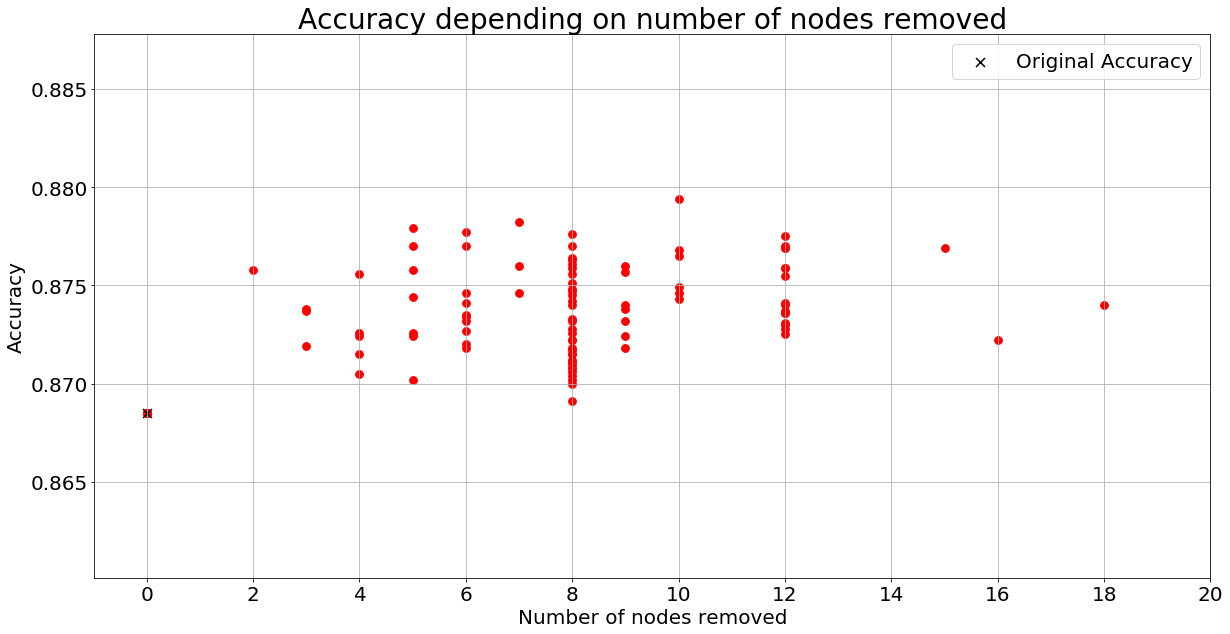

In [38]:
plt.scatter(x=num_removed, y=new_accs, marker='o', color='red', s=60)
plt.scatter(x=0, y=acc, marker='x', color='black', label="Original Accuracy", s=80)
plt.legend(fontsize=20)
plt.title("Accuracy depending on number of nodes removed", size=28)
plt.xlabel("Number of nodes removed", size=20)
plt.xticks(np.arange(0,22,step=2), fontsize=20)
plt.ylabel("Accuracy", size=20)
plt.yticks(fontsize=20)
plt.grid(True)
plt.savefig("../../../figures/Accuracy_vs_nodes_removed_fmnist.png")

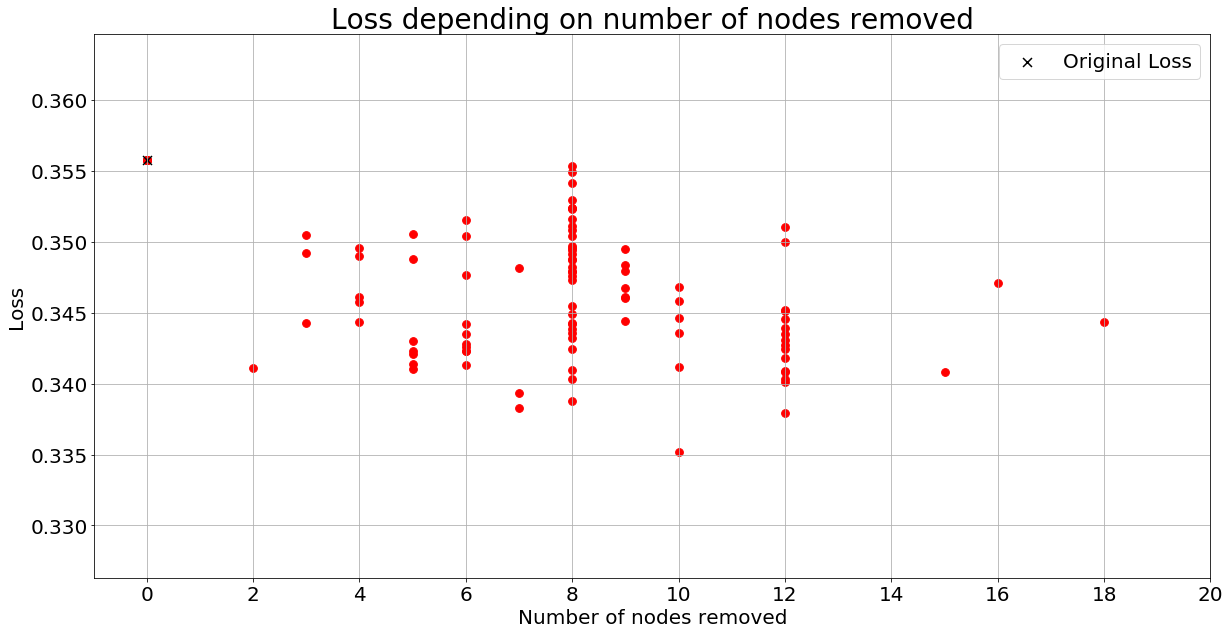

In [39]:
plt.scatter(x=num_removed, y=new_losses, marker='o', color='red', s=60)
plt.scatter(x=0, y=loss, marker='x', color='black', label="Original Loss", s=80)
plt.legend(fontsize=20)
plt.title("Loss depending on number of nodes removed", size=28)
plt.xlabel("Number of nodes removed", size=20)
plt.xticks(np.arange(0,22,step=2), fontsize=20)
plt.ylabel("Loss", size=20)
plt.yticks(fontsize=20)
plt.grid(True)
plt.savefig("../../../figures/Loss_vs_nodes_removed_fmnist.png")